# **6610210301 ภานุพงศ์ สนไชย**

# Lab 06 - Transformations

In this exercise, we will learn how to implement algorithms to find the best fir transformation model from a set of corresponding points.

## 6.0 Setup and Utilities Functions

First, make sure you have installed the required libraries and check what is your *present working directory*:

In [17]:
!pip install numpy matplotlib opencv-python
!echo "Your current directory is: $(pwd)"

Your current directory is: /content


You are provided with some utility functions for reading, writing, and rendering images.

In [83]:
import os
import numpy as np
import matplotlib.pyplot as plt
import cv2

def plot_points(x, xp):

  # Create the plot
  plt.figure(figsize=(12, 6))

  # Scatter plot for the first two columns
  plt.subplot(1, 2, 1)
  plt.scatter(x[:,0], x[:,1], 1, c='blue', alpha=1)
  plt.title('Scatter Plot of First Set')
  plt.xlabel('X-axis')
  plt.ylabel('Y-axis')
  plt.grid(True)

  # Scatter plot for the third and fourth columns
  plt.subplot(1, 2, 2)
  plt.scatter(xp[:,0], xp[:,1], 1, c='red', alpha=1)
  plt.title('Scatter Plot of Second Set')
  plt.xlabel('X-axis')
  plt.ylabel('Y-axis')
  plt.grid(True)

  # Show both plots
  plt.tight_layout()
  plt.show()

## 6.1 Fitting Affine Transformations

Suppose we have a set of 2D correspondences $(x_i,y_i)\leftrightarrow(x'_i,y'_i)$ for $1{\le}i{\le}N$. An actual set of points is in `points_case_1.npy` where each row of the matrix contains the data $(x_i,y_i,x'_i, y'_i)$ representing the correspondence.

Size of dataset1: (4558, 4)


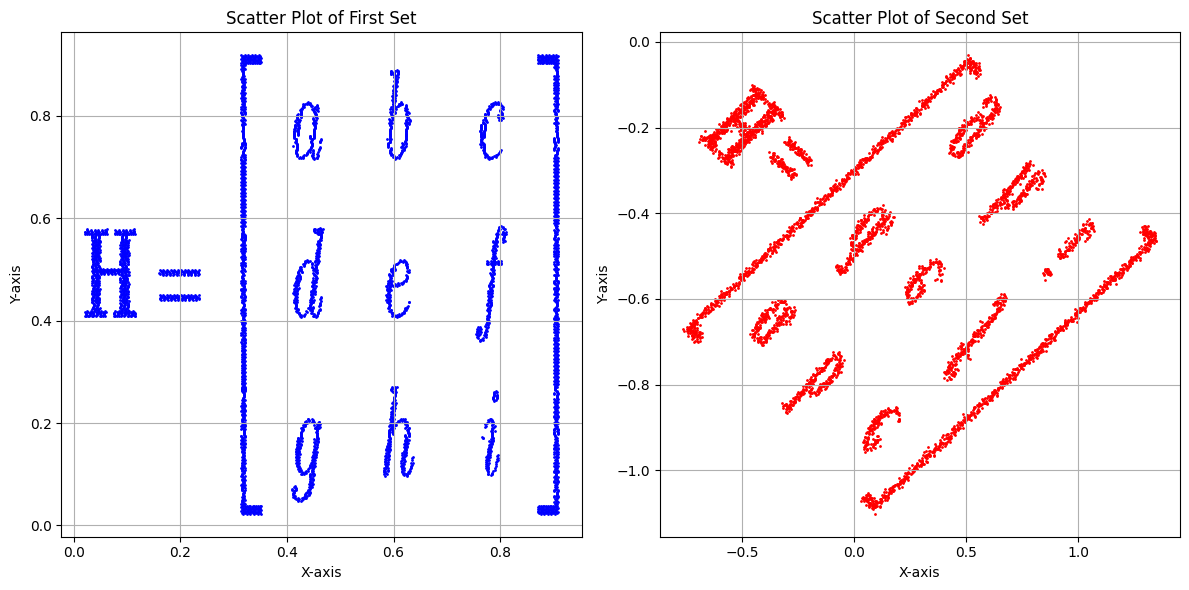

In [104]:
data1 = np.load("points_case_1.npy")
# data1 = np.vstack((data1,[[0,0,1,1],[0,1,1,0],[1,1,0,0]])) #ทำไมพอเติมแล้วมั่ว
print(f"Size of dataset1: {data1.shape}")

# Extract x and y coordinates from the first two columns
x1 = data1[:, :2]  # First two columns

# Extract x' and y' coordinates from the third and fourth columns
xp1 = data1[:, -2:]  # Last two columns

plot_points(x1, xp1)#จะปริ้นให้มันทับกันยังไง

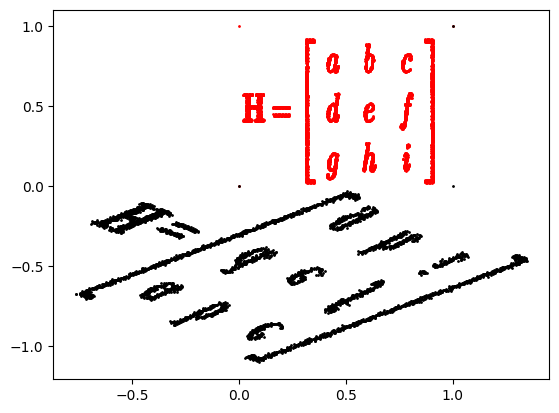

In [85]:
plt.scatter(x1[:,0], x1[:,1], 1, c='red', alpha=1)
plt.scatter(xp1[:,0], xp1[:,1], 1, c="k", alpha=1)

Fit a transformation of the form

$$
[x',y']^T=\textbf{S}[x,y]^T+\textbf{t}, \textbf{S}\in\mathbb{R}^{2\times2}, \textbf{t}\in\mathbb{R}^{2\times1}
$$

by setting up a problem of the form

$$
\underset{\textbf{v}\in\mathbb{R}^{6}}{\text{argmin}}||\textbf{Av}-\textbf{b}||^2_2
$$

and solving it via least-squares.

### Construct $\textbf{A}$

In [86]:
zv = np.zeros((x1.shape[0],1)) # vector of zeros
ov = np.ones((x1.shape[0],1))  # vector of ones

# Construct A matrix

A_even=np.hstack((x1,zv,zv,ov,zv))
A_odd=np.hstack((zv,zv,x1,zv,ov))
A = np.ones((2*x1.shape[0],6))
# A = np.empty((2*x1.shape[0],6))
A[0::2]=A_even
A[1::2]=A_odd

print(f"Size of A = {A.shape}")
print(f"A =\n {A}")
print(f"A 1-2=\n {A[:2,:]}")
print(f"x 1=\n {x1[0,:]}")

Size of A = (9122, 6)
A =
 [[0.314      0.91857143 0.         0.         1.         0.        ]
 [0.         0.         0.314      0.91857143 0.         1.        ]
 [0.32066667 0.91857143 0.         0.         1.         0.        ]
 ...
 [0.         0.         0.         1.         0.         1.        ]
 [1.         1.         0.         0.         1.         0.        ]
 [0.         0.         1.         1.         0.         1.        ]]
A 1-2=
 [[0.314      0.91857143 0.         0.         1.         0.        ]
 [0.         0.         0.314      0.91857143 0.         1.        ]]
x 1=
 [0.314      0.91857143]


### Construct $\textbf{b}$

In [87]:
# Construct b vector
# b = xp1.flatten()
# b=xp1.reshape(-1,1)
b= np.ones((x1.shape[0]*2,1))
bx=xp1[:,0].reshape(-1,1)
by=xp1[:,1].reshape(-1,1)
b[0::2]=bx
b[1::2]=by

print(f"Size of b = {b.shape}")
print(f"b =\n {b}")

Size of b = (9122, 1)
b =
 [[-0.76187091]
 [-0.67491226]
 [-0.74632645]
 ...
 [ 0.        ]
 [ 0.        ]
 [ 0.        ]]


### Solving Least-Squares

In [88]:

v = np.linalg.lstsq(A,b)[0]
print(f"v = \n{v}")

# S = v[:4]
S=np.array([[v[0][0],v[1][0]],
            [v[2][0],v[3][0]]
            ])
print(f"S = \n{S}")
print(f"S = \n{S.shape}")
t=v[4:]
print(f"t = \n{t}")

v = 
[[ 1.41004416]
 [-1.41158674]
 [-0.70770712]
 [-0.70497338]
 [ 0.10160507]
 [ 0.19983108]]
S = 
[[ 1.41004416 -1.41158674]
 [-0.70770712 -0.70497338]]
S = 
(2, 2)
t = 
[[0.10160507]
 [0.19983108]]


### Result

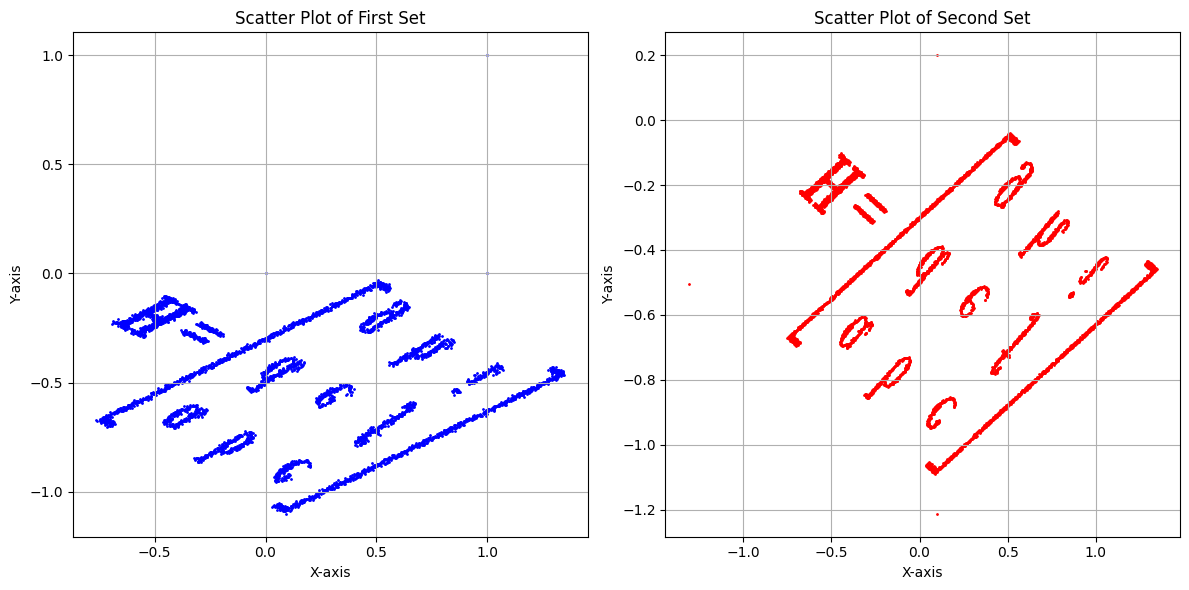

In [89]:
xh1 = np.matmul(S,x1.T)+t #อะไรวะ
plot_points(xp1, xh1.T)

# **do fking ransac**

In [121]:
import random
def fit_affine(x,xp):
  zv = np.zeros((x.shape[0],1)) # vector of zeros
  ov = np.ones((x.shape[0],1))  # vector of ones

  # Construct A matrix

  A_even=np.hstack((x,zv,zv,ov,zv))
  A_odd=np.hstack((zv,zv,x,zv,ov))
  A = np.ones((2*x.shape[0],6))
  # A = np.empty((2*x.shape[0],6))
  A[0::2]=A_even
  A[1::2]=A_odd
  bx=xp[:,0].reshape(-1,1)
  by=xp[:,1].reshape(-1,1)
  b = np.empty((2*x.shape[0],1))
  b[0::2]=bx
  b[1::2]=by
  v = np.linalg.lstsq(A,b)[0]

  S=np.array([[v[0][0],v[1][0]],
            [v[2][0],v[3][0]]
            ])

  t=v[4:]
  return S,t

def ransac_fit_affine(x,xp,n_iter=100,thressold=1,):
    bestline,bestnuminline,bestinliner=None,-1,0
    bests=0
    bestt=0
    for _ in range(n_iter):
      #1random 3 point fromx,xp
      s_indices=random.sample((range(x.shape[0])),3) #random index
      sample_x=x[s_indices]
      sample_xp=xp[s_indices]
      #2fit affine
      s,t=fit_affine(sample_x,sample_xp)
      #3fine best fit model
      num_inlier=0
      inlines=[]
      for i in range(x.shape[0]): #xph= x prime hat
        xph=np.matmul(s,x[i,:].T)+t
        err=np.linalg.norm(xp[i]-xph.T)
      #compute distance to the actual points find error
        if err < thressold:
          num_inlier+=1
          inlines.append(i)

    #update best liner for model
    if num_inlier>bestinliner:
      bestnuminline=num_inlier
      bestinliner=inlines

    bests,bestt=fit_affine(x[bestinliner],xp[bestinliner])
    return  bests,bestt


sbb,tbb=ransac_fit_affine(x1,xp1)

In [122]:
sbb, tbb = ransac_fit_affine(x1, xp1)

In [125]:
xh1 = np.matmul(sbb,x1.T)+tbb

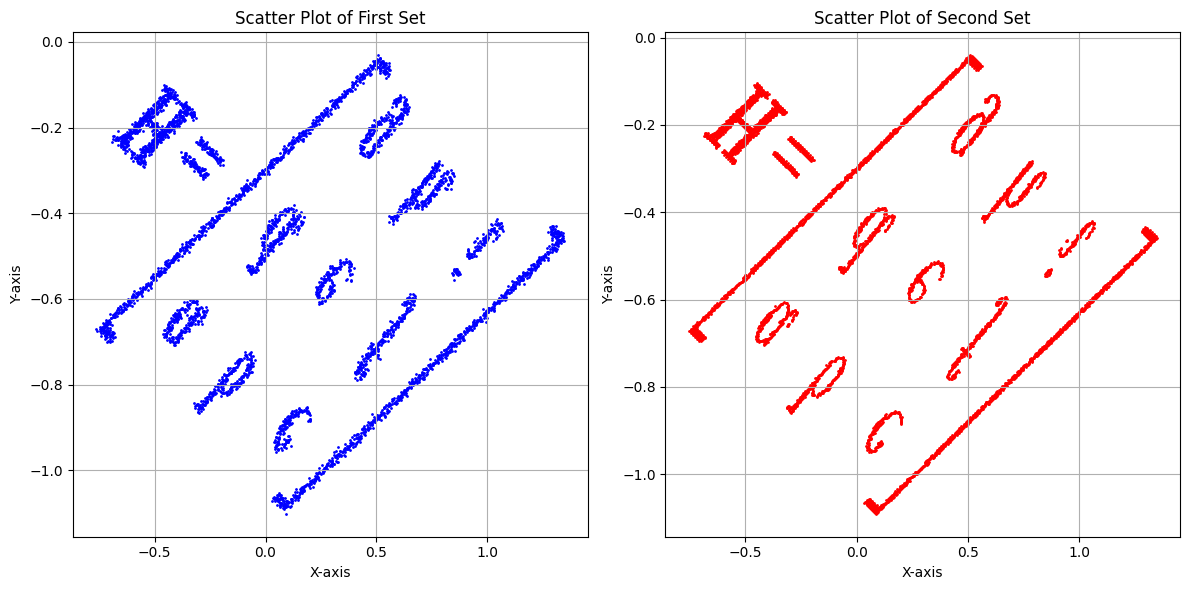

In [127]:
plot_points(xp1, xh1.T)